### Binary cross entropy loss
\begin{equation*}
L(\theta) = - \frac{1}{n} \sum_{i=1}^n [y_i log(p_i) + (1 - y_i) log(1 - p_i)]
\end{equation*}

- Discriminator final probability is 1 => REAL IMAGE
- Discriminator final probability is 0 => FAKE IMAGE

Log values:
- Log(1) => Loss would be 0
- Log(0+) => Loss would be to - ∞

### Generator:

Maximize D(G(z))


### Discriminator:

Maximize D(x) AND minimize D(G(z))

## Some tricks to train GANs
### https://github.com/soumith/ganhacks

In [113]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import cv2
import matplotlib.image as mpimg
import pandas as pd

In [114]:
base_path = "/home/francesco/UQ/Job/Tumour_GAN/"

def normalize(vector, a, b, max_val=255, min_val=0):
    assert(a < b)

    #result = (b - a) * ( (vector - min_val) / (max_val - min_val) ) + a
    result = (vector - 127.5) / 127.5
    
    return result

In [115]:
def getData(path, value="mel", resize=None):
    DF = pd.read_pickle(path)
    assert(len(DF["image"]) == len(DF["id"]))
    
    X = []
    for i in range(len(DF["image"])):
        
        if DF["id"][i] == value:
            if resize is None:
                X.append(DF["image"][i])
            else:
                tmp = cv2.resize(DF["image"][i], (int(resize),int(resize)), interpolation = cv2.INTER_CUBIC)
                X.append(tmp)
                
    return np.array(X)

# Load data
X1 = getData(base_path + "data/NvAndMelTrain.pkl", resize=64)
X2 = getData(base_path + "data/NvAndMelTest.pkl", resize=64)
X_train = np.concatenate((X1, X2), axis=0)
print(X_train.shape)

# Print max and min and normalize
print("MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))
X_train = normalize(X_train, -1, 1)
print("Normalized MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))

assert(X_train.shape[1] == X_train.shape[2])

(614, 64, 64, 3)
MAX : 255 and MIN: 0
Normalized MAX : 1.0 and MIN: -1.0


In [116]:
'''(X_tmp, Y_train), _ = mnist.load_data()
X_train = []
for img in X_tmp:
    tmp = cv2.resize(img, (int(64),int(64)), interpolation = cv2.INTER_CUBIC)
    X_train.append(tmp)
    #X_train.append(img)
    
# Expand to have 1 channel (grey images)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# Print max and min and normalize
print("MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))
X_train = normalize(X_train, -1, 1)
print("Normalized MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))

assert(X_train.shape[1] == X_train.shape[2])'''

'(X_tmp, Y_train), _ = mnist.load_data()\nX_train = []\nfor img in X_tmp:\n    tmp = cv2.resize(img, (int(64),int(64)), interpolation = cv2.INTER_CUBIC)\n    X_train.append(tmp)\n    #X_train.append(img)\n    \n# Expand to have 1 channel (grey images)\nX_train = np.expand_dims(X_train, axis=-1)\nprint(X_train.shape)\n\n# Print max and min and normalize\nprint("MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))\nX_train = normalize(X_train, -1, 1)\nprint("Normalized MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))\n\nassert(X_train.shape[1] == X_train.shape[2])'

In [117]:
# Parameters network and training
epochs = 1000
batchSize = 128
lr = 0.0002
Z_dim = 100
mu, sigma = 0, 1

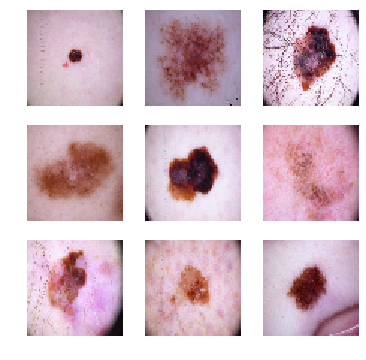

In [118]:
# Show some samples
fig = plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow( ( (X_train[i] * 127.5) + 127.5 ).astype(int) )
    plt.axis('off')

In [122]:
def sample_noise(batch_size, size, mu, sigma):
    #return np.random.normal(mu, sigma, size=[batch_size, 1, 1, size])
    return np.random.uniform(-1., 1., size=[batch_size, size])


def generator(z, trainable, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        fc1 = tf.layers.dense(z, 4*4*1024)
        
        reshaped = tf.reshape(fc1, (-1, 4, 4, 1024))
        bn0 = tf.layers.batch_normalization(reshaped, training=trainable)
        lrelu0 = tf.nn.leaky_relu(bn0)
        
        deconv1 = tf.layers.conv2d_transpose(lrelu0, 512, 5, 1, padding='VALID')
        bn1 = tf.layers.batch_normalization(deconv1, training=trainable)
        lrelu1 = tf.nn.leaky_relu(bn1)
        
        deconv2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, 2, padding='SAME')
        bn2 = tf.layers.batch_normalization(deconv2, training=trainable)
        lrelu2 = tf.nn.leaky_relu(bn2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, 2, padding='SAME')
        bn3 = tf.layers.batch_normalization(deconv3, training=trainable)
        lrelu3 = tf.nn.leaky_relu(bn3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 3, 5, 2, padding='SAME')
        output = tf.tanh(deconv4)
        
        print(z)
        print(fc1)
        print(lrelu0)
        print(lrelu1)
        print(lrelu2)
        print(lrelu3)
        print(output)
        
    return output
    

def discriminator(x, trainable, reuse=False):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(x, 64, 5, 2, 'SAME')
        lrelu1 = tf.nn.leaky_relu(conv1)

        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        bn2 = tf.layers.batch_normalization(conv2, training=trainable)
        lrelu2 = tf.nn.leaky_relu(bn2)

        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 2, 'SAME')
        bn3 = tf.layers.batch_normalization(conv3, training=trainable)
        lrelu3 = tf.nn.leaky_relu(bn3)
        
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 2, 'SAME')
        bn4 = tf.layers.batch_normalization(conv4, training=trainable)
        lrelu4 = tf.nn.leaky_relu(bn4)

        reshaped = tf.reshape(lrelu4, (-1, 4*4*256))
        logits = tf.layers.dense(reshaped, 1)
        probability = tf.sigmoid(logits)
    
    if not reuse:
        print(x)
        print(lrelu1)
        print(lrelu2)
        print(lrelu3)
        print(lrelu4)
        print(reshaped)
        print(probability)

    return probability, logits

In [124]:
tf.reset_default_graph()

# Inputs
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')
X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], X_train.shape[3]], name='X')
isTrain = tf.placeholder(dtype=tf.bool)

# Networks
G_z = generator(Z, isTrain)
_, D_logits_real = discriminator(X, isTrain)
_, D_logits_fake = discriminator(G_z, isTrain, reuse=True)

Tensor("Z:0", shape=(?, 100), dtype=float32)
Tensor("generator/dense/BiasAdd:0", shape=(?, 16384), dtype=float32)
Tensor("generator/LeakyRelu:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("generator/LeakyRelu_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("generator/LeakyRelu_2:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("generator/LeakyRelu_3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("discriminator/LeakyRelu:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("discriminator/LeakyRelu_1:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("discriminator/LeakyRelu_2:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("discriminator/LeakyRelu_3:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator/Reshape:0", shape=(?, 4096), dtype=float32)
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)


In [125]:
def discriminatorLoss(D_logits_real, D_logits_fake, label_smoothing=1):
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,
                                                labels=tf.ones_like(D_logits_real) * label_smoothing))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                labels=tf.zeros_like(D_logits_fake)))
    D_loss = D_loss_real + D_loss_fake
    
    return D_loss

def generatorLoss(D_logits_fake):
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                labels=tf.ones_like(D_logits_fake)))
    return G_loss

D_loss = discriminatorLoss(D_logits_real, D_logits_fake, 0.9)
G_loss = generatorLoss(D_logits_fake)

# Losses have minus sign because I have to maximize them
#D_loss = - tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_fake))
#G_loss = - tf.reduce_mean(tf.log(D_fake))

all_vars = tf.trainable_variables()
D_vars = [var for var in all_vars if var.name.startswith('discriminator')]
G_vars = [var for var in all_vars if var.name.startswith('generator')]

# Optimize
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops): 
    D_optimizer = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optimizer = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

## Training of the generator and discriminator network

In [ ]:
tf.summary.scalar('D_loss', D_loss)
tf.summary.scalar('G_loss', G_loss)

# MERGE SUMMARIES - Merge all summaries into a single op
merged_summ = tf.summary.merge_all()

# VISUALIZE => tensorboard --logdir=.
summaries_dir = base_path + "checkpoints"

# Test noise
testNoise = sample_noise(6, Z_dim, mu, sigma)
print(testNoise.shape)

def saveImages(images, epoch):    
    for i in range(len(images)):
        mpimg.imsave(base_path + "images/out-" + str(epoch) + "-" + str(i) + ".png", np.squeeze(G_output[i]))

(6, 100)


In [ ]:
indices = list(range(len(X_train)))

with tf.Session() as sess:

    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter(summaries_dir, graph=tf.get_default_graph())
    
    globalStep = 0
    for i in range(epochs):        
        # Shuffle dataset every epoch
        print("Epoch " + str(i))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        
        for j in range(0, len(X_train), batchSize):
            noise = sample_noise(len(X_train[j:j+batchSize]), Z_dim, mu, sigma)

            _ = sess.run(D_optimizer, feed_dict={ X: X_train[j:j+batchSize], 
                                                  Z: noise,
                                                  isTrain: True})

            noise = sample_noise(len(X_train[j:j+batchSize]), Z_dim, mu, sigma)
            _, summary = sess.run([G_optimizer, merged_summ], feed_dict={ X: X_train[j:j+batchSize],
                                                                          Z: noise,
                                                                          isTrain: True })
            globalStep+=1
            summary_writer.add_summary(summary, globalStep)

        # Check results every epoch
        save_path = saver.save(sess, base_path + "checkpoints/model.ckpt")
        G_output = sess.run(G_z, feed_dict={ Z: testNoise,
                                            isTrain: False })
        saveImages(G_output, i)

Epoch 0
